In [1]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
import torch.nn as nn
import torch

In [2]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [3]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [4]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [5]:
Bv

array([[-4.3300e-02, -2.3550e-02,  9.5380e-01],
       [-2.5400e-02,  1.2450e-02,  9.2760e-01],
       [ 7.1000e-03,  5.9650e-02,  9.0820e-01],
       [-5.0175e-02, -1.9900e-02,  9.7690e-01],
       [-2.3275e-02,  1.5000e-03,  9.6190e-01],
       [ 1.8225e-02,  3.4100e-02,  9.5370e-01],
       [-6.4100e-02, -2.9250e-02,  9.8540e-01],
       [-2.8200e-02, -2.2450e-02,  9.8160e-01],
       [ 2.2300e-02, -4.4500e-03,  9.8460e-01],
       [-2.7625e-02, -2.6000e-02,  9.6830e-01],
       [-1.9250e-03,  1.9000e-02,  9.5670e-01],
       [ 3.8375e-02,  7.5200e-02,  9.5190e-01],
       [-3.2700e-02, -2.9400e-02,  1.0004e+00],
       [ 5.1300e-02,  4.2600e-02,  1.0064e+00],
       [-4.4825e-02, -4.5800e-02,  1.0179e+00],
       [-1.1250e-03, -3.0000e-02,  1.0287e+00],
       [ 5.7175e-02, -3.0000e-03,  1.0463e+00],
       [-1.9500e-02, -2.6650e-02,  9.9060e-01],
       [ 1.4000e-02,  2.7350e-02,  9.9360e-01],
       [ 6.2100e-02,  9.2550e-02,  1.0034e+00],
       [-2.2775e-02, -3.7100e-02,  1.031

In [6]:
# normalized the data, but note that we are dividing all the columns by a constant value 
# (so that they will satisfy the Maxwell's equations) 
def normalized_data(data):
    data_mean = np.mean(data,axis=0)
    data_std  = np.std(data,axis=0)
    data_mag  = data_std.sum()
    data_norm = (data -data_mean)/data_mag
    return data_mean,data_mag,data_norm
    

In [7]:
Bv_mean,Bv_mag,Bv_norm = normalized_data(Bv)
Bv_norm                                             # normalized BVs 

array([[-0.35596766, -0.19291404, -0.36303987],
       [-0.21530936,  0.08997417, -0.56891962],
       [ 0.04007583,  0.46087204, -0.72136493],
       [-0.40999145, -0.16423232, -0.18151993],
       [-0.1986111 ,  0.003929  , -0.29939002],
       [ 0.12749614,  0.26009999, -0.36382567],
       [-0.51941418, -0.23770467, -0.11472688],
       [-0.23731177, -0.18427023, -0.14458731],
       [ 0.15951752, -0.04282613, -0.12101329],
       [-0.23279342, -0.21216615, -0.24909878],
       [-0.03084267,  0.1414441 , -0.34025165],
       [ 0.28583496,  0.58306403, -0.37797008],
       [-0.2726728 , -0.23888337,  0.0031432 ],
       [ 0.38739968,  0.32689304,  0.05029124],
       [-0.36795112, -0.36775467,  0.1406583 ],
       [-0.02455627, -0.24359818,  0.22552476],
       [ 0.43356547, -0.03143202,  0.36382567],
       [-0.16894712, -0.21727386, -0.07386525],
       [ 0.09429607,  0.20705845, -0.05029124],
       [ 0.47226614,  0.71940043,  0.02671722],
       [-0.19468209, -0.29939002,  0.249

In [8]:
# function to scale the field back to original scale 
def un_normalied_data(norm_data,norm_data_mag,norm_data_mean):
    return (norm_data*norm_data_mag + norm_data_mean)

In [9]:
Bv_back = un_normalied_data(Bv_norm,Bv_mag,Bv_mean)

In [10]:
Bv_back

array([[-4.3300e-02, -2.3550e-02,  9.5380e-01],
       [-2.5400e-02,  1.2450e-02,  9.2760e-01],
       [ 7.1000e-03,  5.9650e-02,  9.0820e-01],
       [-5.0175e-02, -1.9900e-02,  9.7690e-01],
       [-2.3275e-02,  1.5000e-03,  9.6190e-01],
       [ 1.8225e-02,  3.4100e-02,  9.5370e-01],
       [-6.4100e-02, -2.9250e-02,  9.8540e-01],
       [-2.8200e-02, -2.2450e-02,  9.8160e-01],
       [ 2.2300e-02, -4.4500e-03,  9.8460e-01],
       [-2.7625e-02, -2.6000e-02,  9.6830e-01],
       [-1.9250e-03,  1.9000e-02,  9.5670e-01],
       [ 3.8375e-02,  7.5200e-02,  9.5190e-01],
       [-3.2700e-02, -2.9400e-02,  1.0004e+00],
       [ 5.1300e-02,  4.2600e-02,  1.0064e+00],
       [-4.4825e-02, -4.5800e-02,  1.0179e+00],
       [-1.1250e-03, -3.0000e-02,  1.0287e+00],
       [ 5.7175e-02, -3.0000e-03,  1.0463e+00],
       [-1.9500e-02, -2.6650e-02,  9.9060e-01],
       [ 1.4000e-02,  2.7350e-02,  9.9360e-01],
       [ 6.2100e-02,  9.2550e-02,  1.0034e+00],
       [-2.2775e-02, -3.7100e-02,  1.031

In [11]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T
Bv_coords = torch.from_numpy(Bv_coords).type(torch.float32)      # convert to torch.tensor

In [12]:
# physics BV coords 
PBv_coords = np.array([xv[~bv_mask],yv[~bv_mask],zv[~bv_mask]]).T
PBv_coords = torch.from_numpy(PBv_coords).type(torch.float32).requires_grad_(True)     
PBv_coords

tensor([[-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        [-1.0000, -1.0000, -0.4000],
        ...,
        [ 1.0000,  1.0000,  0.4000],
        [ 1.0000,  1.0000,  0.6000],
        [ 1.0000,  1.0000,  0.8000]], requires_grad=True)

In [13]:
# Bvs (magentic field at boundaries)-> note we are using normalized values 
Bv = torch.from_numpy(Bv_norm).type(torch.float32)

In [14]:
class FFNN(nn.Module):
    def __init__(self,input_features,output_features,hidden_feature):
        super().__init__()
        self.layer_1 = nn.Linear(input_features,hidden_feature)
        self.layer_2 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_3 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_4 = nn.Linear(hidden_feature,output_features)
        self.activation = nn.Tanh()
        
    def forward(self,x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.layer_4(x)
        return x 
        

In [15]:
model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    B_pred = model(Bv_coords) # prediction from FFNN 
    loss = loss_fn(B_pred,Bv) # data loss, using the BVs 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.3f}')
    

epoch:0 | train loss:0.136
epoch:100 | train loss:0.011
epoch:200 | train loss:0.007


epoch:300 | train loss:0.004
epoch:400 | train loss:0.002
epoch:500 | train loss:0.001
epoch:600 | train loss:0.001
epoch:700 | train loss:0.001
epoch:800 | train loss:0.001
epoch:900 | train loss:0.000


In [17]:
# test the PINN model 

z = torch.from_numpy(np.array([[0,0,i] for i in np.linspace(-1,1,11)])).type(torch.float32)
Bz_pred = model(z)
Bz_pred = Bz_pred.detach().numpy()
Bz_pred = un_normalied_data(Bz_pred,Bv_mag,Bv_mean) # go back to the original scale 

z_axis_mask = (xv==0) * (yv==0)     # mask to select data along z axis 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bz = B[z_axis_mask]                 # Bz along z axis 

Text(0, 0.5, '$B_y$')

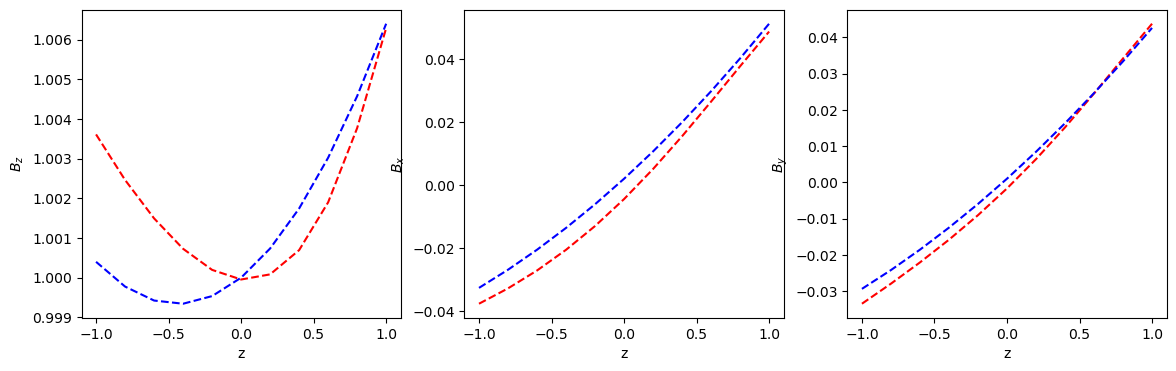

In [18]:
# plot the magnetic field 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(z[:,2],Bz_pred[:,2],'r--',label='pred')
ax1.plot(z[:,2],Bz[:,2],'b--',label='actaul')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$B_z$')

ax2.plot(z[:,2],Bz_pred[:,0],'r--',label='pred')
ax2.plot(z[:,2],Bz[:,0],'b--',label='actaul')
ax2.set_xlabel('z')
ax2.set_ylabel(r'$B_x$')

ax3.plot(z[:,2],Bz_pred[:,1],'r--',label='pred')
ax3.plot(z[:,2],Bz[:,1],'b--',label='actaul')
ax3.set_xlabel('z')
ax3.set_ylabel(r'$B_y$')

In [19]:
Bhp = model(PBv_coords)
Bhp

tensor([[-0.3185, -0.1281, -0.4088],
        [-0.2938, -0.0811, -0.4444],
        [-0.2659, -0.0289, -0.4820],
        ...,
        [ 0.3575, -0.1877,  0.7722],
        [ 0.4613, -0.1241,  0.8144],
        [ 0.5592, -0.0575,  0.8493]], grad_fn=<AddmmBackward0>)

In [20]:
torch.autograd.grad(Bhp,PBv_coords,torch.ones_like(Bhp))[0].shape

torch.Size([1305, 3])

### Why we didn't get [batch_size,output_dim,input_dim]?

* Jacobian matrix find the gradients and it is normally has shape of [output_dim,input_dim]

* But when we called **torch.autograd.grad** we get [batch_size,input_dim], this is because the grad function sums the gradients along the "output dim"

* To get the full Jacobian matrix we can use **torch.autograd.functional.jacobian()**, this returns [batch_size,output_dim,batch_size,input_dim]

In [21]:
#using torch.autograd.functional.jacobian
B_jacob = torch.autograd.functional.jacobian(lambda t:model(t),PBv_coords) # (batch_size, output_dim, batch_size, input_dim)
#the off-diagonal elements of 0th and 2nd dimension are all zero. So we remove them
B_grad  = torch.diagonal(B_jacob,offset=0,dim1=0,dim2=2)                   # (output_dim, input_dim, batch_size)
B_grad  = B_grad.permute(2,0,1)                                            # (batch_size, output_dim, input_dim)    

In [22]:
B_grad

tensor([[[ 0.0826, -0.0408,  0.1169],
         [-0.0287, -0.0105,  0.2228],
         [ 0.1419,  0.2640, -0.1724]],

        [[ 0.0863, -0.0296,  0.1308],
         [-0.0185, -0.0097,  0.2481],
         [ 0.1501,  0.2700, -0.1835]],

        [[ 0.0900, -0.0160,  0.1495],
         [-0.0059, -0.0133,  0.2737],
         [ 0.1589,  0.2766, -0.1923]],

        ...,

        [[ 0.2244, -0.0143,  0.5268],
         [ 0.0534, -0.3167,  0.3049],
         [ 0.4412,  0.2255,  0.2266]],

        [[ 0.2170, -0.0163,  0.5074],
         [ 0.0715, -0.3390,  0.3281],
         [ 0.4401,  0.2242,  0.1937]],

        [[ 0.2046, -0.0183,  0.4684],
         [ 0.0828, -0.3559,  0.3349],
         [ 0.4315,  0.2212,  0.1537]]])

In [23]:
# implement del.B = 0 
del_dot_B = torch.diagonal(B_grad,offset=0,dim1=1,dim2=2).sum(dim=1)

In [24]:
# implement del.cross.B 
del_cross_B = B_grad[:,0,1] + B_grad[:,1,0] + B_grad[:,0,2] + B_grad[:,2,0] + B_grad[:,1,2] + B_grad[:,2,1]
del_cross_B

tensor([0.6760, 0.7508, 0.8369,  ..., 1.5376, 1.5549, 1.5206])

In [25]:
# physics infromed NN 

phy_model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(phy_model.parameters(),lr=0.001)
phy_loss_strength = 1e-2

epochs = 500

for epoch in range(epochs):
    phy_model.train()
    # BCs 
    B_pred = phy_model(Bv_coords) # prediction from FFNN
    bv_loss = loss_fn(B_pred,Bv) # data loss, using the BVs, note: here Bvs are normalized values 
    
    # use physics BCs 
    B_jacob = torch.autograd.functional.jacobian(lambda t:phy_model(t),PBv_coords)
    B_grad  = torch.diagonal(B_jacob,offset=0,dim1=0,dim2=2)                   
    B_grad  = B_grad.permute(2,0,1)
    
    # implement del.B = 0 
    del_dot_B = torch.diagonal(B_grad,offset=0,dim1=1,dim2=2).sum(dim=1)
    # implement del.cross.B(Note: each x,y and z components need to be zero -seperatly)
    del_cross_B_x = B_grad[:,0,1] + B_grad[:,1,0] 
    del_cross_B_y = B_grad[:,0,2] + B_grad[:,2,0] 
    del_cross_B_z = B_grad[:,1,2] + B_grad[:,2,1]
    # physics loss 
    phy_loss = phy_loss_strength * (torch.mean(del_dot_B**2) + torch.mean(del_cross_B_x**2) +\
                        torch.mean(del_cross_B_y**2) + torch.mean(del_cross_B_z**2))
    # total loss 
    loss = bv_loss + phy_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%50 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.5f}')
    

epoch:0 | train loss:0.11084
epoch:50 | train loss:0.02789
epoch:100 | train loss:0.01806
epoch:150 | train loss:0.01555
epoch:200 | train loss:0.01362
epoch:250 | train loss:0.01213
epoch:300 | train loss:0.01120
epoch:350 | train loss:0.01064
epoch:400 | train loss:0.01021
epoch:450 | train loss:0.00986


In [26]:
# test the PINN model 

z = torch.from_numpy(np.array([[0,0,i] for i in np.linspace(-1,1,11)])).type(torch.float32)
Bz_pred = phy_model(z)
Bz_pred = Bz_pred.detach().numpy()
Bz_pred = un_normalied_data(Bz_pred,Bv_mag,Bv_mean) # go back to the original scale 


In [27]:
z_axis_mask = (xv==0) * (yv==0)     # mask to select data along z axis 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bz = B[z_axis_mask]                 # Bz along z axis 
Bz

array([[-3.270000e-02, -2.940000e-02,  1.000400e+00],
       [-2.692800e-02, -2.421600e-02,  9.997760e-01],
       [-2.057200e-02, -1.858400e-02,  9.994240e-01],
       [-1.363200e-02, -1.250400e-02,  9.993440e-01],
       [-6.108000e-03, -5.976000e-03,  9.995360e-01],
       [ 2.000000e-03,  1.000000e-03,  1.000000e+00],
       [ 1.069200e-02,  8.424000e-03,  1.000736e+00],
       [ 1.996800e-02,  1.629600e-02,  1.001744e+00],
       [ 2.982800e-02,  2.461600e-02,  1.003024e+00],
       [ 4.027200e-02,  3.338400e-02,  1.004576e+00],
       [ 5.130000e-02,  4.260000e-02,  1.006400e+00]])

Text(0, 0.5, '$B_y$')

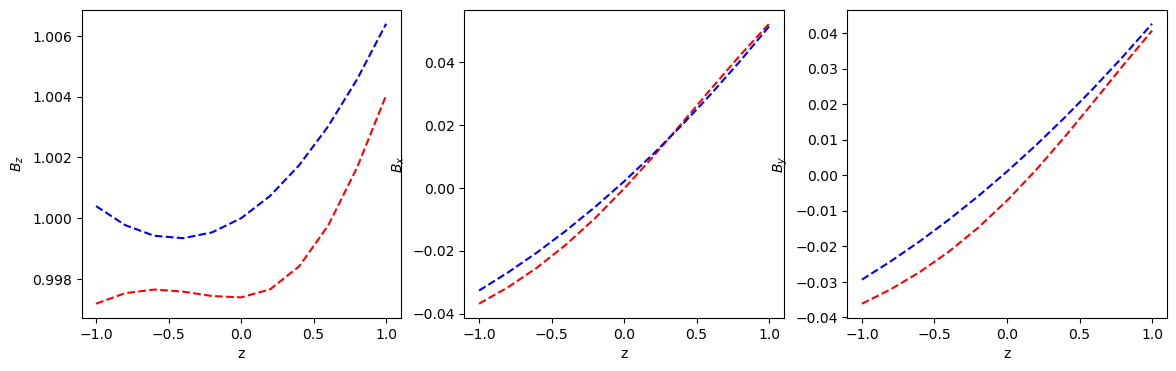

In [28]:
# plot the magnetic field 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(z[:,2],Bz_pred[:,2],'r--',label='pred')
ax1.plot(z[:,2],Bz[:,2],'b--',label='actaul')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$B_z$')

ax2.plot(z[:,2],Bz_pred[:,0],'r--',label='pred')
ax2.plot(z[:,2],Bz[:,0],'b--',label='actaul')
ax2.set_xlabel('z')
ax2.set_ylabel(r'$B_x$')

ax3.plot(z[:,2],Bz_pred[:,1],'r--',label='pred')
ax3.plot(z[:,2],Bz[:,1],'b--',label='actaul')
ax3.set_xlabel('z')
ax3.set_ylabel(r'$B_y$')